## Load data

In [44]:
# sys.path.append("..")

# %cd ..
# from src.utils import *
from utils import *
# %cd notebooks

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

account_df = read_to_df("account.csv")
card_test_df = read_to_df("card_test.csv")
card_train_df = read_to_df("card_train.csv")
client_df = read_to_df("client.csv")
disp_df = read_to_df("disp.csv")
district_df = read_to_df("district.csv")
loan_test_df = read_to_df("loan_test.csv")
loan_train_df = read_to_df("loan_train.csv")
trans_test_df = read_to_df("trans_test.csv")
trans_train_df = read_to_df("trans_train.csv")


<ipython-input-44-31079ad28951>:22: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans_train_df = read_to_df("trans_train.csv")


## Process account data

In [45]:
account_df.head()


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


## Process client data

In [46]:
client_df["sex"] = client_df["birth_number"].apply(
    lambda x: 0 if int(str(x)[2:4]) > 50 else 1)
client_df["age"] = client_df["birth_number"].apply(
    lambda x: calculate_age(read_date(x)))
client_df.drop("birth_number", inplace=True, axis=1)

client_df.head()


,client_id,district_id,sex,age
0,1,18,0,28
1,2,1,1,53
2,3,1,0,58
3,4,5,1,42
4,5,5,0,38


In [47]:
client_district_df = client_df.join(district_df)
client_district_df.head()


,client_id,district_id,sex,age,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,18,0,28,1.0,Hl.m. Praha,Prague,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,12541.0,0.29,0.43,167.0,85677,99107.0
1,2,1,1,53,2.0,Benesov,central Bohemia,88884.0,80.0,26.0,6.0,2.0,5.0,46.7,8507.0,1.67,1.85,132.0,2159,2674.0
2,3,1,0,58,3.0,Beroun,central Bohemia,75232.0,55.0,26.0,4.0,1.0,5.0,41.7,8980.0,1.95,2.21,111.0,2824,2813.0
3,4,5,1,42,4.0,Kladno,central Bohemia,149893.0,63.0,29.0,6.0,2.0,6.0,67.4,9753.0,4.64,5.05,109.0,5244,5892.0
4,5,5,0,38,5.0,Kolin,central Bohemia,95616.0,65.0,30.0,4.0,1.0,6.0,51.4,9307.0,3.85,4.43,118.0,2616,3040.0


In [48]:
joined_loan_test_df = loan_test_df.merge(card_test_df.merge(
    disp_df, on="disp_id", how="left"), on="account_id", how="left")
joined_loan_test_df.rename(columns={"type_x": "card_type"}, inplace=True)
joined_loan_test_df["card_type"].replace(
    {"classic": 1, "junior": 2, "gold": 3}, inplace=True)

joined_loan_test_df.head()
loan_test_df.head()


,loan_id,account_id,date,amount,duration,payments,status
0,5895,4473,970103,93960,60,1566,NaN
1,7122,10365,970104,260640,36,7240,NaN
2,6173,5724,970108,232560,48,4845,NaN
3,6142,5591,970121,221880,60,3698,NaN
4,5358,2018,970121,38520,12,3210,NaN


In [49]:
joined_loan_train_df = loan_train_df.merge(
    card_train_df.merge(disp_df, on="disp_id"), on="account_id")
joined_loan_train_df.rename(columns={"type_x": "card_type"}, inplace=True)

# Replace text with numeric data
joined_loan_train_df["card_type"].replace(
    {"classic": 1, "junior": 2, "gold": 3}, inplace=True)
joined_loan_train_df["type_y"].replace({"OWNER": 1, "USER": 2}, inplace=True)

joined_loan_train_df.head(50)
# joined_loan_train_df.count() #Doesn't count NA values


,loan_id,account_id,date,amount,duration,payments,status,card_id,disp_id,card_type,issued,client_id,type_y
0,6577,7753,940311,51696,24,2154,1,1005,9285,1,931107,9593,1
1,5595,3050,940902,82896,12,6908,1,577,3687,1,940215,3687,1
2,7243,11042,951204,217152,36,6032,1,1225,13268,1,951122,13576,1
3,5900,4503,960101,135360,48,2820,1,783,5433,2,951024,5433,1
4,6550,7614,960518,320592,48,6679,1,989,9119,1,960221,9427,1
5,5311,1766,960615,30060,60,501,1,337,2141,1,960101,2141,1
6,6992,9790,960727,133968,48,2791,1,1134,11742,1,960531,12050,1
7,7305,11359,960806,54024,12,4502,1,1247,13660,1,950613,13968,1
8,5088,544,960822,91152,24,3798,1,119,655,1,960808,655,1
9,7154,10520,961205,417600,60,6960,1,1187,12635,3,960717,12943,1


In [50]:
loan_train_df.head()


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


## Train model and predict

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = loan_train_df.drop(["loan_id", "account_id", "status"], axis=1)
y = loan_train_df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

# Create Decision Tree classifier object
classifier = DecisionTreeClassifier()

# Train Decision Tree classifier
classifier = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


## Metrics


In [52]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)


0.7926829268292683

# Classifiers

Columns to drop and feature target:

In [53]:
columns_to_drop = ["loan_id", "account_id", "status"]
target_column = "status"
loan_test_df.drop(columns_to_drop, axis=1)


,date,amount,duration,payments
0,970103,93960,60,1566
1,970104,260640,36,7240
2,970108,232560,48,4845
3,970121,221880,60,3698
4,970121,38520,12,3210
...,...,...,...,...
349,981205,352704,48,7348
350,981205,52512,12,4376
351,981206,139488,24,5812
352,981206,55632,24,2318


## Decision Tree

Best score: 0.9254951160062486
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}


[Text(167.40000000000003, 195.696, 'X[3] <= 7265.0\nentropy = 0.585\nsamples = 328\nvalue = [46, 282]'),
 Text(66.96000000000001, 152.208, 'X[3] <= 1609.0\nentropy = 0.504\nsamples = 296\nvalue = [33, 263]'),
 Text(33.480000000000004, 108.72, 'entropy = 0.0\nsamples = 46\nvalue = [0, 46]'),
 Text(100.44000000000001, 108.72, 'X[1] <= 321078.0\nentropy = 0.563\nsamples = 250\nvalue = [33, 217]'),
 Text(66.96000000000001, 65.232, 'X[0] <= 931222.0\nentropy = 0.585\nsamples = 235\nvalue = [33, 202]'),
 Text(33.480000000000004, 21.744, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(100.44000000000001, 21.744, 'entropy = 0.61\nsamples = 220\nvalue = [33, 187]'),
 Text(133.92000000000002, 65.232, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(267.84000000000003, 152.208, 'X[3] <= 8323.5\nentropy = 0.974\nsamples = 32\nvalue = [13, 19]'),
 Text(234.36, 108.72, 'X[1] <= 96282.0\nentropy = 0.999\nsamples = 25\nvalue = [13, 12]'),
 Text(200.88000000000002, 65.232, 'entropy = 0.0\n

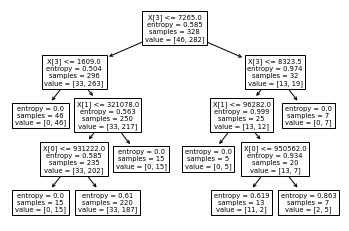

In [54]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

# No feature selection
dt = tune_model(loan_train_df, DecisionTreeClassifier(),
                parameter_grid, columns_to_drop, target_column)
plot_tree(dt.best_estimator_)


## SVM
Needs to be scaled (StandardScaler)

In [55]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    # 'kernel': ['linear', 'poly', 'rbf']
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# No feature selection
svc = tune_model(loan_train_df, SVC(), parameter_grid,
                 columns_to_drop, target_column, scaler=StandardScaler())
svc.best_estimator_


Best score: 0.9245831129913625
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


SVC(C=1, gamma=0.001, kernel='linear')

# K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [56]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

# No feature selection
knn = neighbors.KNeighborsClassifier()
knn = tune_model(loan_train_df, neighbors.KNeighborsClassifier(
), parameter_grid, columns_to_drop, target_column, scaler=StandardScaler())


Best score: 0.9253360999321794
Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 10}


# Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

# No feature selection
nb = tune_model(loan_train_df, GaussianNB(),
                         parameter_grid, columns_to_drop, target_column, scaler=StandardScaler())


Best score: 0.9152708004108172
Best parameters: {}


# Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

# No feature selection
rfc = tune_model(
    loan_train_df, RandomForestClassifier(), parameter_grid, columns_to_drop, target_column)


Best score: 0.9253903738555481
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1}


# Comparing Models

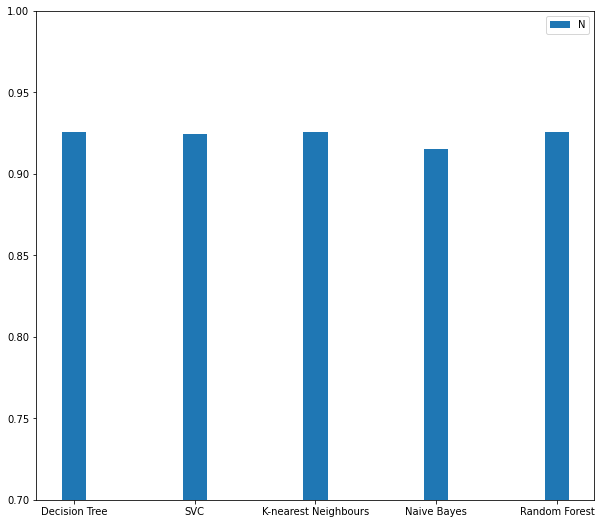

In [61]:
import numpy as np

scores = {
    "Decision Tree" : [dt], #[dt_original, dt, dt_os_fs],
    "SVC" : [svc], #[svc_original, svc, svc_os_fs],
    "K-nearest Neighbours" : [knn], #[knn_original, knn, knn_os_fs],
    "Naive Bayes" : [nb], #[nb_original, nb, nb_os_fs],
    "Random Forest" : [rfc], #[rfc_original, rfc, rfc_os_fs]
}

labels ="No Feature selection" # ["No oversampling/No feature selection","No oversampling/Feature selection", "Oversampling/Feature selection"]

ind = np.arange(5)

plt.figure(figsize=(10,9))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
plt.xticks(ind, scores.keys())
plt.legend(labels,loc=1)
plt.ylim(0.7, 1)
plt.show()

## Save results

In [ ]:
X_result = loan_test_df.drop(["loan_id", "account_id", "status"], axis=1)

y_result = classifier.predict(X_result)

result = pd.DataFrame({"Id": loan_test_df["loan_id"], "Predicted": y_result})
result.to_csv("../out/result.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../out/result.csv'